In [1]:
import os
import datetime
import errno

import numpy as np

import deepcell
from deepcell.utils.tracking_utils import load_trks, trks_stats
from deepcell.utils.misc_utils import sorted_nicely
from deepcell.utils.tracking_utils import load_trks

/opt/conda/lib/python3.7/site-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


In [2]:
from deepcell import model_zoo

# Tracking model settings (These settings should mirror those from Part 1)
##features = {'appearance', 'distance', 'neighborhood', 'regionprop'}

##min_track_length = 9
##neighborhood_scale_size = 30
##batch_size = 128  
##crop_dim = 32

features = {'appearance', 'distance', 'neighborhood', 'regionprop'}
min_track_length = 9
neighborhood_scale_size = 30
batch_size = 16  # changed  
crop_dim = 100  # changed

# Re-instantiate the tracking model
tracking_model = model_zoo.siamese_model(
    input_shape=(crop_dim, crop_dim, 1),
    neighborhood_scale_size=neighborhood_scale_size,
    features=features)

# Load model weights
PREFIX = 'test_0814'
ROOT_DIR = '../train_0814'
MODEL_DIR = os.path.abspath(os.path.join(ROOT_DIR, 'models', PREFIX))

siamese_weights_file = 'tracking_model_seed1_tl9.h5'
siamese_weights_file = os.path.join(MODEL_DIR, siamese_weights_file)

tracking_model.load_weights(siamese_weights_file)

In [3]:
# Define Critical Parameters 
# Key variables are lists to facilitate parameter sweeps if desired

# If model prediction for daughter is higher than this parameter,
# then daughter assignment made
##division = [0.9]
division = [0]

# Parameter for cost matrix - if other possible assignments are higher than this,
# then a birth occurred
##birth = [0.99]
birth = [0]

# Parameter for cost matrix - if other possible assignments are higher than this,
# then a death occurred
death = [0.99]

# If two labels are beyond this distance they will not be compared
# (smaller distances -> faster tracking)
## max_distance = 50
max_distance = 500  ## Is it too big?

# Define Parameters that should not be changed
# (they are model dependent or training data dependent)
track_length = 9
neighborhood_scale_size = 30

In [4]:
tracking_model

In [5]:
import deepcell.tracking

In [ ]:
for set_num, dataset in enumerate(GT_trks_files):
    trks = load_trks(dataset)
    # Go through each batch (movie) in each dataset
    for batch_num, (lineage, raw, tracked) in enumerate(zip(trks['lineages'], trks['X'], trks['y'])):        
        # Normalize raw images
        for frame in range(raw.shape[0]):
            raw[frame, :, :, 0] = image_norm(raw[frame, :, :, 0]) 

        # Track each movie with each division parameter
        print('Tracking: Dataset {}, Batch {}'.format(set_num, batch_num))
        for div_param in division:
            # For each birth parameter
            for birth_param in birth:
                # For each death parameter
                for death_param in death:
                    pass
                    # Track with the selected parameters
                    trial = deepcell.tracking.cell_tracker(
                        raw, tracked, tracking_model,
                        max_distance=max_distance,
                        track_length=track_length,
                        division=div_param,
                        birth=birth_param,
                        death=death_param,
                        neighborhood_scale_size=neighborhood_scale_size,
                        features=features)

                    trial.track_cells()
                    
                    # Run FP post processing and save the result in the correct location
                    file_name = 'batch_{}_div{}_b{}_d{}'.format(
                        str(batch_num).zfill(3),
                        str(div_param).zfill(3),
                        str(birth_param).zfill(3),
                        str(death_param).zfill(3))
                    file_path = os.path.join(TRACK_DIRS[set_num], file_name)
                    fp_fixed_trk = trial.postprocess(file_path)


In [ ]:
# Try segmentation first... 

In [8]:
from deepcell.applications import CytoplasmSegmentation

video = np.load('../6823_3/D12_raw_1.npy')

app = CytoplasmSegmentation()
print('Training Resolution:', app.model_mpp, 'microns per pixel')

labeled_video = app.predict(video[0:2], image_mpp=12.4)
labeled_video.shape

Training Resolution: 0.65 microns per pixel


(2, 530, 530, 1)

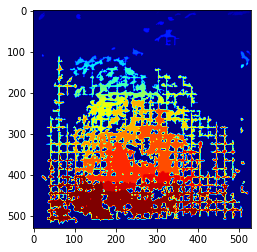

In [9]:
import matplotlib.pyplot as plt
plt.imshow(labeled_video[0], cmap='jet')

## Segment the cells using trained weight file 

In [1]:
import deepcell
from deepcell.utils.data_utils import get_data

train_dict, test_dict = get_data(
    '../test.npz',
    mode='sample',
    test_size=1,
    seed=0)

ImportError: cannot import name 'LayerNormalization' from 'tensorflow.python.keras.layers.normalization' (/opt/conda/lib/python3.7/site-packages/tensorflow/python/keras/layers/normalization/__init__.py)

In [2]:
train_dict['X'].shape
X_train = train_dict['X']

In [3]:
X_train.shape

(65, 100, 530, 530, 1)

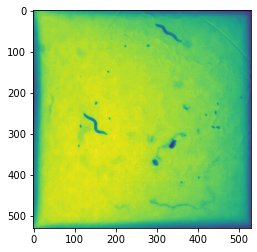

In [4]:
import matplotlib.pyplot as plt

plt.imshow(X_train[2][10])

In [5]:
X_train_2 = X_train[2]
X_train_2.shape

(100, 530, 530, 1)

## Track the segmented cells 

In [12]:
from keras.models import load_model
import cv2
import numpy as np
from tensorflow.keras.optimizers import SGD
from deepcell.utils.train_utils import rate_scheduler
from deepcell import losses

model = load_model(siamese_weights_file)

n_classes = tracking_model.layers[-1].output_shape[-1]

def loss_function(y_true, y_pred):
    return losses.weighted_categorical_crossentropy(y_true, y_pred,
                                                    n_classes=n_classes,
                                                    from_logits=False)

optimizer = SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)

model.compile(loss=loss_function,
              optimizer=optimizer,
              metrics=['accuracy'])


ValueError: Unknown loss function: loss_function. Please ensure this object is passed to the `custom_objects` argument. See https://www.tensorflow.org/guide/keras/save_and_serialize#registering_the_custom_object for details.